In [105]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math

## Function to calculate normalization values

In [113]:
def get_normalize_params(domain='human', data_transform=None, batch_size=128, num_samples=1000):
    if isinstance(domain, str):    # convert str to lowercase
        domain = domain.lower()
    
    if domain == 'human':    # map 'human' to 0, 'anime' to 1
        domain = 0
    elif domain == 'anime':
        domain = 1

    if domain not in [0,1]:    # ensure domain value is valid
        raise Exception('Invalid value given for domain')


    if data_transform is None:    # default transform if None is passed
        data_transform = transforms.Compose([
                         transforms.Resize(int(128 * 1.12), Image.BICUBIC),
                         transforms.RandomCrop(128),
                         transforms.ToTensor()])

    trainset = datasets.ImageFolder(root='human2anime',    # dataset
                                    transform=data_transform)
    targets = torch.tensor(trainset.targets)    # targets    
    target_idx = (targets==domain).nonzero()    # indexes of images from specified domain
    sampler = torch.utils.data.sampler.SubsetRandomSampler(target_idx)    # sampler to choose images from specified domain
    loader = torch.utils.data.DataLoader(trainset, sampler=sampler, batch_size=batch_size, num_workers=0)    # loader with sampler

    # calculate mean/std
    mean = 0.
    std = 0.
    nb_samples = 0.
    iter_lim = math.ceil(num_samples/batch_size)
    for i, data in enumerate(loader):
        data = data[0]
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples
        if i == iter_lim:    # limit iterations to only calculate mean/std for num_samples 
            break

    mean /= nb_samples
    std /= nb_samples

    return mean, std

In [112]:
# print mean & std of each set
print('Human')
h_mean, h_std = get_normalize_params(domain='human')
print(f'mean: {h_mean}\nstd: {h_std}\n')
print('Anime')
a_mean, a_std = get_normalize_params(domain='anime')
print(f'mean: {a_mean}\nstd: {a_std}')

Human
mean: tensor([0.5189, 0.4201, 0.3754])
std: tensor([0.2489, 0.2210, 0.2134])

Anime
mean: tensor([0.6838, 0.5831, 0.5667])
std: tensor([0.2633, 0.2716, 0.2449])


## Dataset + loader

In [114]:
# create dataset with ImageFolder
data_transform = transforms.Compose([
                 transforms.Resize(int(128 * 1.12), Image.BICUBIC),
                 transforms.RandomCrop(128),
                 transforms.RandomHorizontalFlip(),
                 transforms.ToTensor()])

trainset = datasets.ImageFolder(root='human2anime', transform=data_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)

## Functions to display images

In [118]:
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

def show_faces(dataset, imgs_per_row=4, rows=4, type=None):
    """Display random images from either domain, with options.

    Parameters:
        dataset     -- Pytorch dataset of images  
        imgs_per_row (int) -- number of images to display per row
        rows (int)         -- number of rows of images to display
        type               -- Which class of image to display. Options are 'human', 'anime', or None to randomly select from either class. 
    """
    if type is None:
        for i in range(rows):
            loader = torch.utils.data.DataLoader(dataset, batch_size=imgs_per_row, shuffle=True, num_workers=0)
            dataiter = iter(loader)
            images, labels = dataiter.next()
            imshow(torchvision.utils.make_grid(images))

    else:
        if isinstance(type, str):    # make 'type' lowercase
            type = type.lower()

        if type == 'human':
            targets = torch.tensor(dataset.targets)
            target_idx = (targets==0).nonzero()    # indexes of images with class 0
            sampler = torch.utils.data.sampler.SubsetRandomSampler(target_idx)    # sampler for selecting images from class 0  
            for i in range(rows):
                loader = torch.utils.data.DataLoader(dataset, sampler=sampler, batch_size=imgs_per_row, num_workers=0)
                dataiter = iter(loader)
                images, labels = dataiter.next()
                imshow(torchvision.utils.make_grid(images))

        elif type == 'anime':
            targets = torch.tensor(dataset.targets)
            target_idx = (targets==1).nonzero()    # indexes of images with class 1
            sampler = torch.utils.data.sampler.SubsetRandomSampler(target_idx)    # sampler for selecting images from class 1
            for i in range(rows):
                loader = torch.utils.data.DataLoader(dataset, sampler=sampler, batch_size=imgs_per_row, num_workers=0)
                dataiter = iter(loader)
                images, labels = dataiter.next()
                imshow(torchvision.utils.make_grid(images))

Human Faces


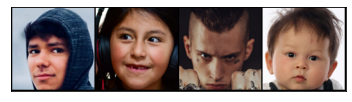

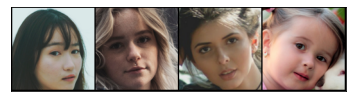

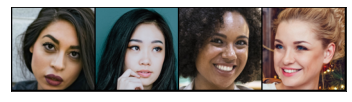

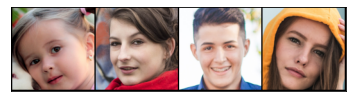

Anime Faces


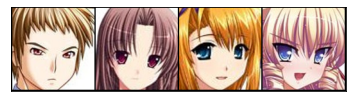

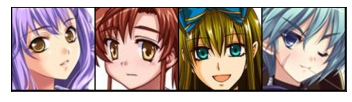

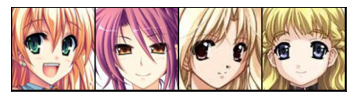

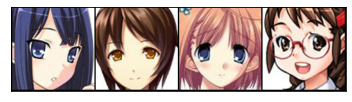

In [117]:
print('Human Faces')
show_faces(trainset, imgs_per_row=4, rows=4, type='human')

print('Anime Faces')
show_faces(trainset, imgs_per_row=4, rows=4, type='anime')